# E-commerce Sales Analytics

## Introduction
Sales is the most important factor in e-commerce company as it generates revenue from the platform fee from each transaction.

In this project, we aim to *Explore* order items data to find interesting insights to Olist to improve their sales.

This data used is Brazilian E-Commerce Public Dataset by Olist which is download from https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data

## Exploratory Data Analysis (EDA)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import gc

pd.set_option('display.max_columns', None)

In [2]:
# where do the customers stay
customer_data = pd.read_csv(r'data/olist_customers_dataset.csv')

# geolocation longitute and latitue of the customers
geolocation_data = pd.read_csv(r'data/olist_geolocation_dataset.csv')

# order details with product id, seller id, shipping info, product price and freight fee
order_items_data = pd.read_csv(r'data/olist_order_items_dataset.csv')

# order with payment details like payment type, installments and payment value
order_payments_data = pd.read_csv(r'data/olist_order_payments_dataset.csv')

# order review id with review score, title, message, creation date and answer timestamp
order_reviews_data = pd.read_csv(r'data/olist_order_reviews_dataset.csv')

# order status with customer id, order purchase timestamp, approved time, delivery carrier date, 
# delivery to customer date and order estimated delivery date  
orders_data = pd.read_csv(r'data/olist_orders_dataset.csv')

# product info with id, category name, length product name, length product description, quantity of product photos,
# product weight, product length in cm, product height in cm, product width in cm
products_data = pd.read_csv(r'data/olist_products_dataset.csv')

# sellers info with seller zip code, city and state
sellers_data = pd.read_csv(r'data/olist_sellers_dataset.csv')

# product category translation from brazilian to english
product_category_name_translation_data = pd.read_csv(r'data/product_category_name_translation.csv')

As the data is incomplete for year 2016 and 2018, we will only use 2017 data in this project.

In [3]:
# translate the products data from Brasilian to English
products_data = pd.merge(products_data, product_category_name_translation_data, how='left', on='product_category_name')
products_data.drop('product_category_name', axis=1, inplace=True)
products_data.rename(columns = {'product_category_name_english' : 'product_category_name'}, inplace=True)

# generate master dataframe
main_df = pd.merge(order_items_data, orders_data[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']], how='left', on='order_id')
main_df['order_purchase_timestamp'] = pd.to_datetime(main_df['order_purchase_timestamp'])
main_df['order_purchase_month'] = main_df['order_purchase_timestamp'].dt.month
main_df['order_purchase_year'] = main_df['order_purchase_timestamp'].dt.year
main_df['order_purchase_hour'] = main_df['order_purchase_timestamp'].dt.hour

# we only analyse orders that are delivered
main_df = main_df[main_df['order_status']=='delivered']

# filter to 2017 data
main_df = main_df[main_df['order_purchase_year']==2017]

main_df = pd.merge(main_df, products_data[['product_id', 'product_category_name']], how='left', on='product_id')
main_df = pd.merge(main_df, customer_data, how='left', on='customer_id')
main_df = pd.merge(main_df, order_reviews_data[['order_id', 'review_score'
                                              ]], how='left', on='order_id')
main_df.drop_duplicates(inplace=True)

The top 5 product category listed on olist platform are bed_bath_table, sports_leisure, furniture_decor, healthy_beauty and housewares.

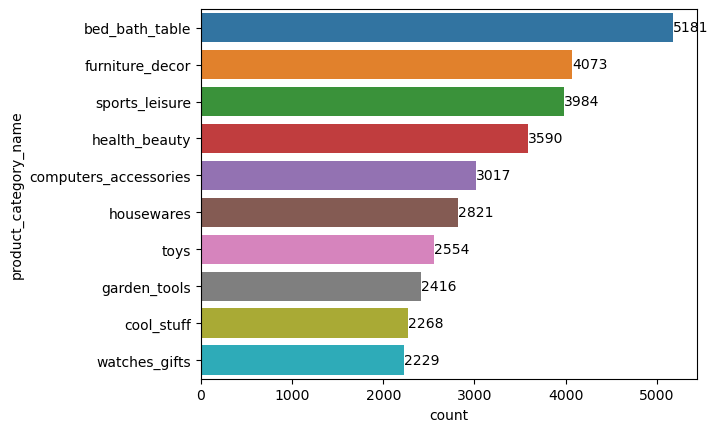

In [5]:
# top 10 product category listed in olist
top_products_store = main_df['product_category_name'].value_counts().reset_index().head(10)

ax = sns.barplot(top_products_store, x='count', y='product_category_name')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/top_listed_product_category.jpeg')

Top 5 product category that brings the highest revenues are healthy_beauty, watches_gifts, bed_bath_table, sports_leisure and computers_accessories.

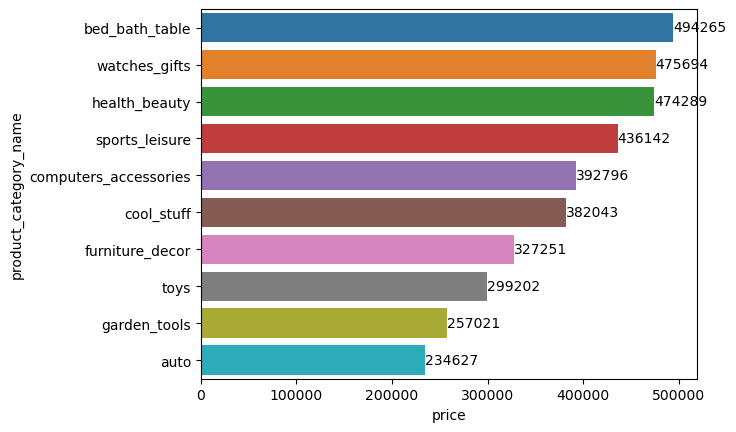

In [6]:
# top 10 product category with highest revenue
top_products_revenue = main_df.groupby('product_category_name')['price'].sum().reset_index().sort_values('price', ascending=False).head(10)

ax = sns.barplot(top_products_revenue, x='price', y='product_category_name')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/top_revenue_product_category.jpeg')

Top 5 product category that brings the highest sales are bed_bath_table, healthy_beauty, sports_leisure, furniture_decor and computers_accessories.

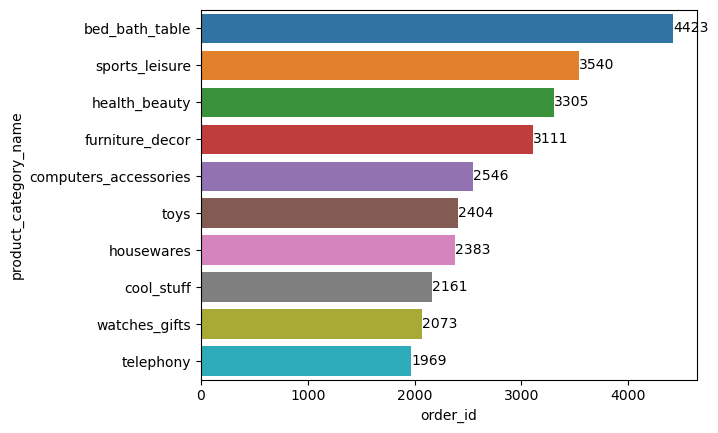

In [7]:
# top 10 product category with highest sales
top_products_sales = main_df.groupby('product_category_name')['order_id'].nunique().reset_index().sort_values('order_id', ascending=False).head(10)

ax = sns.barplot(top_products_sales, x='order_id', y='product_category_name')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/top_sales_product_category.jpeg')

Majority of the reviews are given 5-star follows by 4-star and 1-star. It appears that customers are less likely to write 2-star and 3-star review in a 5-star range.

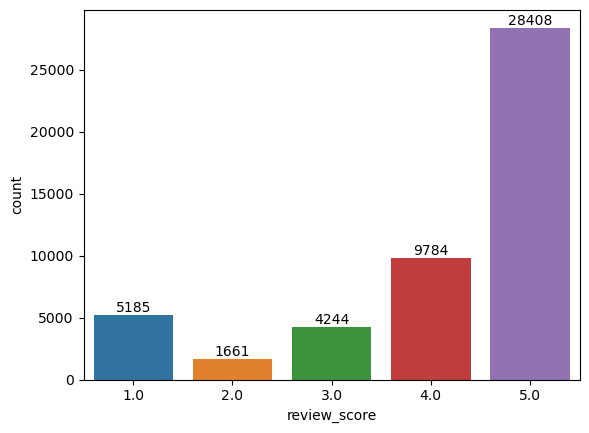

In [8]:
# order reviews
order_reviews = main_df['review_score'].value_counts().reset_index().sort_values('review_score')

ax = sns.barplot(order_reviews, x='review_score', y='count')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/review_score_counts.jpeg')

Lowest review top 5 products category are construction_tools_lights, office_furniture, small_appliances_home_oven_and_coffee, security_and_services and diapers_and_hygiene. Despite of low ratings, office_furniture product has high no of sales.

In [9]:
product_sales_review = main_df.groupby('product_category_name').aggregate({'order_id' : 'nunique',
                                                                                      'review_score' : 'mean'
                                                                                     }).reset_index().sort_values('order_id', ascending=False)
product_sales_review.rename(columns = {'order_id' : 'no_of_sales'}, inplace=True)
product_sales_review.sort_values('review_score', ascending=False, inplace=True)

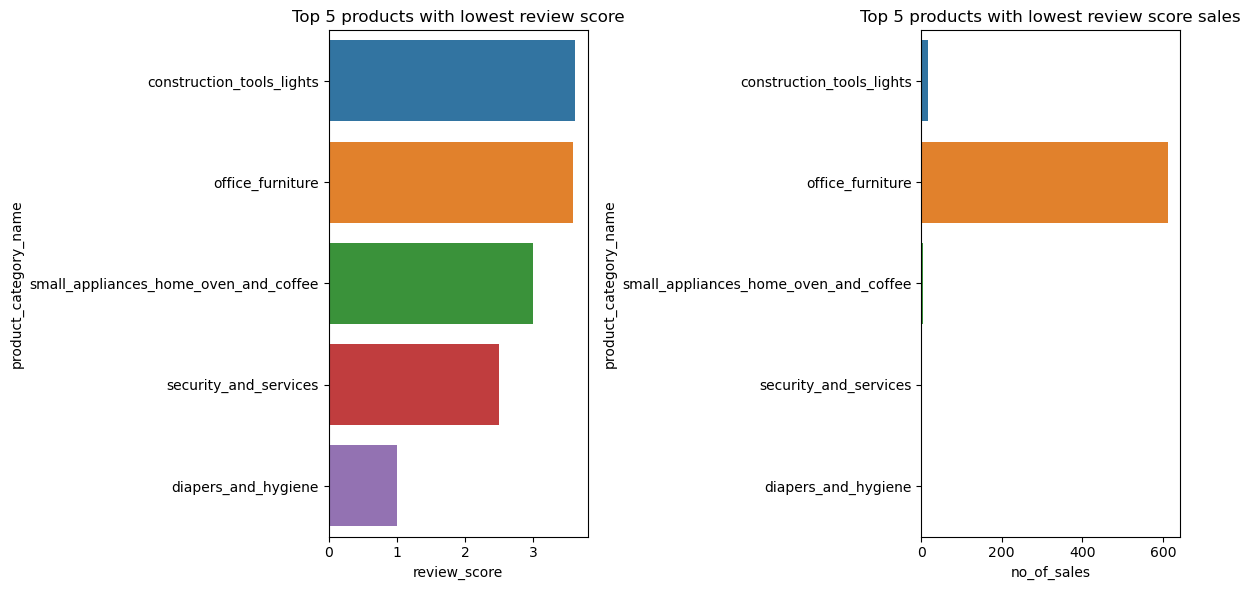

In [10]:
# top 5 product category with lowest reviews
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(product_sales_review.tail(5).sort_values('review_score', ascending=False), x='review_score', y='product_category_name', ax=axes[0])
axes[0].set_title('Top 5 products with lowest review score')

sns.barplot(product_sales_review.tail(5).sort_values('review_score', ascending=False), x='no_of_sales', y='product_category_name', ax=axes[1])
axes[1].set_title('Top 5 products with lowest review score sales')

plt.tight_layout()

Top 5 products with highest review score are arts_and_craftmanship, fashion_chilrens_clothes, cds_dvds_musicals, la_cuisine and books_general_interest. Similarly to top 5 product with lowest review score, the reviews score does not translate to no of sales.

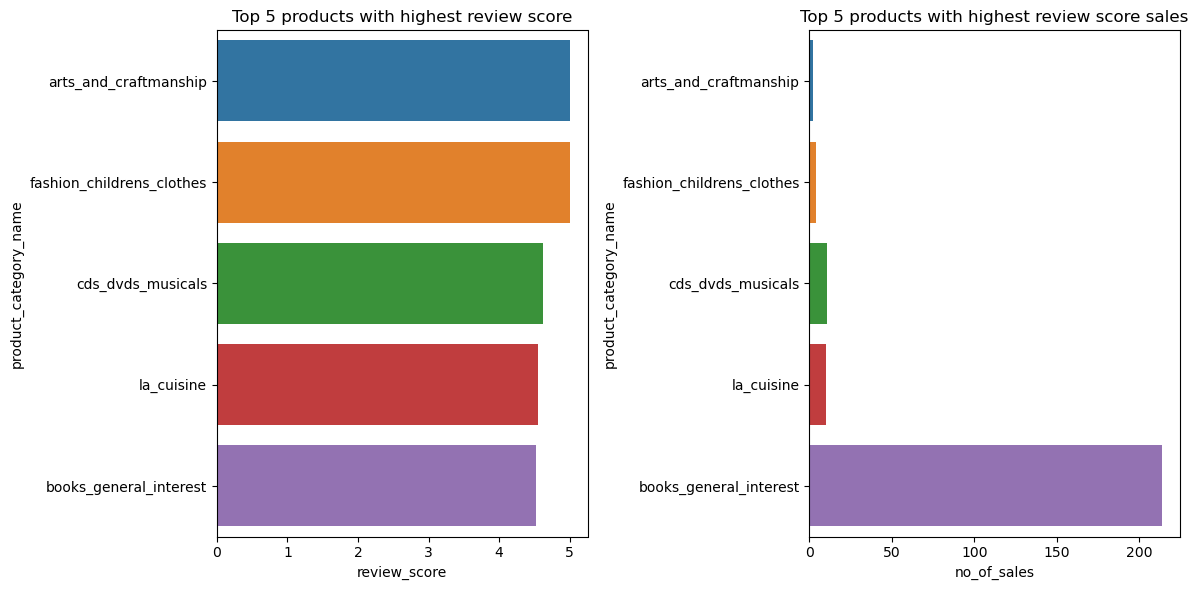

In [11]:
# top 5 product category with highest reviews
# product_review = order_product_review.groupby('product_category_name')['review_score'].mean().reset_index().sort_values('review_score')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(product_sales_review.head(5).sort_values('review_score', ascending=False), x='review_score', y='product_category_name', ax=axes[0])
axes[0].set_title('Top 5 products with highest review score')

sns.barplot(product_sales_review.head(5).sort_values('review_score', ascending=False), x='no_of_sales', y='product_category_name', ax=axes[1])
axes[1].set_title('Top 5 products with highest review score sales')

plt.tight_layout()

From the scatterplot, we can see that higher no of sales happen on review score between 4 to 4-5 star. We can also see that review_score does not correlate directly with no_of_sales.

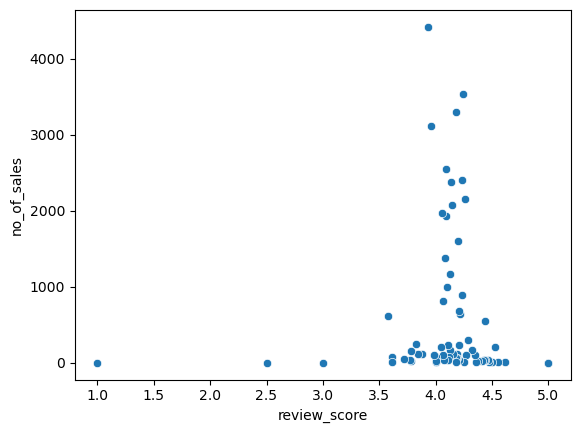

In [12]:
sns.scatterplot(product_sales_review, x='review_score', y='no_of_sales')
plt.savefig(r'plot/review_score_sales_correlation.jpeg')

Most freight fee is around 25.

C:\Users\a\anaconda3\envs\data-science-gpu-3.8\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


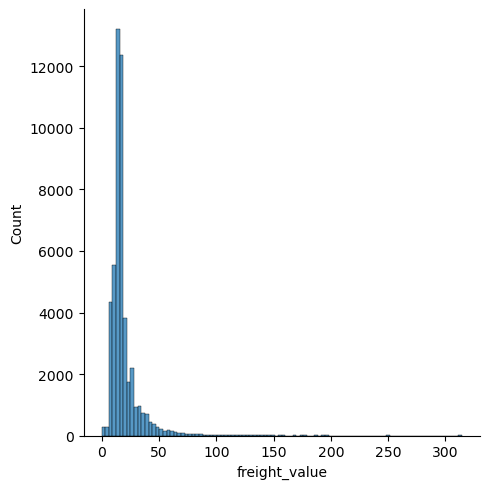

In [12]:
# average freight fee
sns.displot(main_df['freight_value'], bins=100)

Most order has fee less than 250

C:\Users\a\anaconda3\envs\data-science-gpu-3.8\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


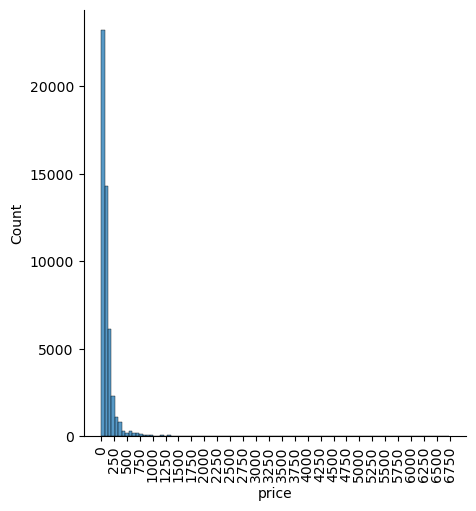

In [13]:
# average order fee
ax = sns.displot(main_df['price'], bins=100)
ax.set(xticks = np.arange(0, 7000, 250))
ax.set_xticklabels(np.arange(0, 7000, 250), rotation=90)

Based on the average sales per month, it appears that the sales increase during November, possibly due to people stocking up for Christmas.

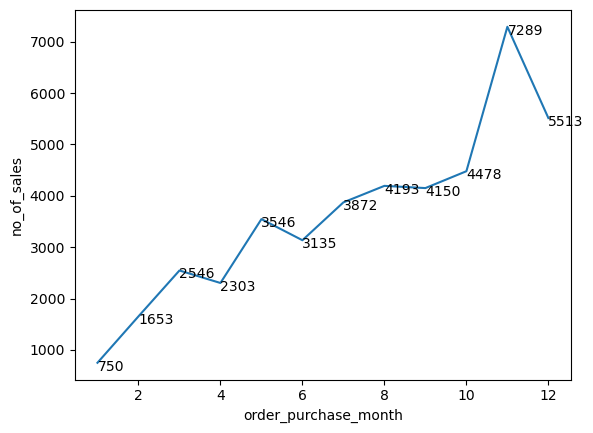

In [13]:
sales_month = main_df.groupby(['order_purchase_year', 'order_purchase_month'])['order_id'].nunique().reset_index()
sales_month = sales_month.groupby('order_purchase_month')['order_id'].mean().reset_index()
sales_month.rename(columns = {'order_id' : 'no_of_sales'}, inplace=True)

ax = sns.lineplot(sales_month, x='order_purchase_month', y='no_of_sales')

# label points on the plot
for x, y in zip(sales_month['order_purchase_month'], sales_month['no_of_sales']):
    # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
    plt.text(x = x, # x-coordinate position of data label
             y = y-150, # y-coordinate position of data label, adjusted to be 150 below the data point
             s = '{:.0f}'.format(y)) # data label, formatted to ignore decimals
    
plt.savefig(r'plot/sales_time_series.jpeg')

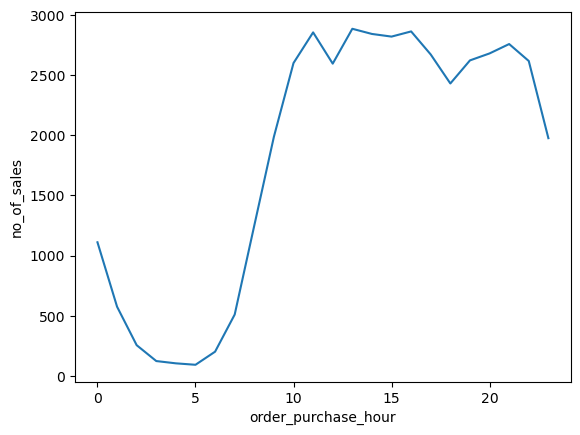

In [14]:
sales_hour = main_df.groupby(['order_purchase_year', 'order_purchase_hour'])['order_id'].nunique().reset_index()
sales_hour = sales_hour.groupby('order_purchase_hour')['order_id'].mean().reset_index()
sales_hour.rename(columns = {'order_id' : 'no_of_sales'}, inplace=True)

ax = sns.lineplot(sales_hour, x='order_purchase_hour', y='no_of_sales')

plt.savefig(r'plot/transactions_time.jpeg')

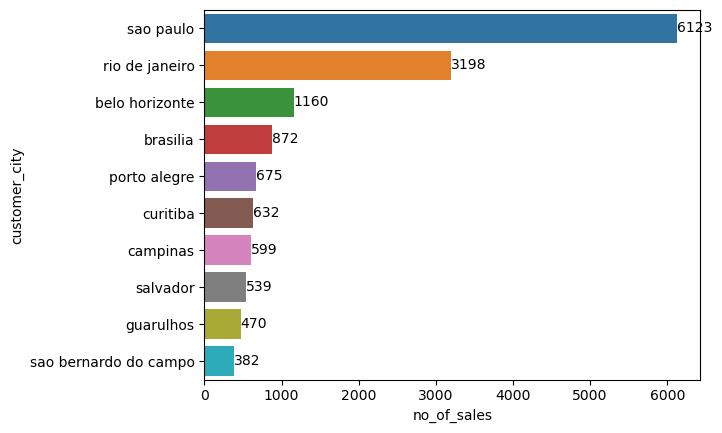

In [15]:
sales_city = main_df.groupby(['customer_city'])['order_id'].nunique().reset_index().sort_values('order_id', ascending=False).head(10)
sales_city.rename(columns = {'order_id' : 'no_of_sales'}, inplace=True)

ax = sns.barplot(sales_city, x='no_of_sales', y='customer_city')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/top_customers_city.jpeg')

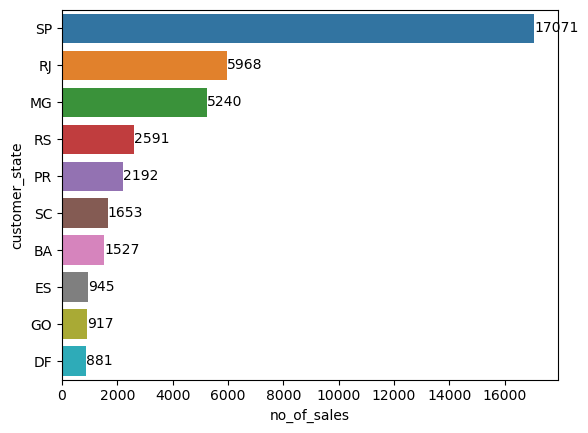

In [16]:
sales_state = main_df.groupby(['customer_state'])['order_id'].nunique().reset_index().sort_values('order_id', ascending=False).head(10)
sales_state.rename(columns = {'order_id' : 'no_of_sales'}, inplace=True)

ax = sns.barplot(sales_state, x='no_of_sales', y='customer_state')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/top_customers_state.jpeg')

## Findings

These are the findings from the e-commerce analytics:
- Most of the transactions happen from 10 AM till midnight. If the merchants want to do flash sale, they need to do it after 10 AM for effective marketing
- November is the month with highest transactions. The merchants should aim to clear their stocks at this month
- High review score does not translate to higher sales of products
- These are the top 10 products category with highest sales on the platform: bed_bath_table, sports_leisure, health_beauty, furniture_decor, computers_accessories, toys, housewares, cool_stuff, watches_gifts, telephony. New merchants or existing merchants can aim to expand to these products category to increase their overall sales
- Top 3 sales are made from customers from these cities: sao paulo, rio de janeiro, and belo horizonte. Similarly, top 3 sales are made from these states: SP, RJ and MG. Merchants would want to target these cities or states to boost overall sales